# Example of openloop gate optimization

### Import and definitions

In [1]:
import copy
import numpy as np
import tensorflow as tf
from scipy.linalg import expm

In [2]:
import c3po.control as control
import c3po.component as component
import c3po.generator as generator
import c3po.envelopes as envelopes
import c3po.hamiltonians as hamiltonians

In [3]:
from c3po.model import Model as Mdl
from c3po.simulator import Simulator as Sim
from c3po.optimizer import Optimizer as Opt
from c3po.experiment import Experiment as Exp

In [4]:
from c3po.utils import log_setup
from c3po.tf_utils import tf_limit_gpu_memory, tf_abs, tf_ave, tf_kron
from c3po.qt_utils import basis, xy_basis, perfect_gate, perfect_CZ

### Specify parameters of the system

In [5]:
# System
qubit_freq1 = 5.805e9 * 2 * np.pi
qubit_anhar1 = -0.217e9 * 2 * np.pi 

qubit_freq2 = 5.238e9 * 2 * np.pi
qubit_anhar2 = -0.226e9 * 2 * np.pi

g_coupling = 42 * 1e6 * 2 * np.pi
qubit_lvls = 3

coupling_ham = hamiltonians.int_YY
mw_ham = hamiltonians.y_drive
flux_ham = hamiltonians.z_drive

v_hz_conversion = 1 # this allows you to put voltage as amplitude and it will convert them to Hz
#t_final = 26e-9
t_final = int(1.1 * 2 * np.pi / g_coupling / 1e-9) * 1e-9 # length of the gates

env_freq = 0.5 / t_final * 2 * np.pi

In [6]:
t_final

2.6e-08

In [7]:
# Resolutions
sim_res = 250e9
awg_res = 250e9 # this high resolution is needed to simulate the high frequency components in the drive 

In [8]:
# Directory to log into
logdir = log_setup("/tmp/c3logs/")

### Create model object that contains information on the Hamiltonians

In [9]:
q1 = component.Qubit(
    name="q1",
    desc="Qubit 1",
    comment="the higher frequency qubit",
    freq=qubit_freq1,
    anhar=qubit_anhar1,
    hilbert_dim=qubit_lvls
)
q2 = component.Qubit(
    name="q2",
    desc="Qubit 2",
    comment="the lower frequency qubit",
    freq=qubit_freq2,
    anhar=qubit_anhar2,
    hilbert_dim=qubit_lvls
)
mw1 = component.Drive(
    name="mw1",
    desc="Microwave drive line 1, driving qubit 1",
    connected=["q1"],
    hamiltonian=mw_ham
)
mw2 = component.Drive(
    name="mw2",
    desc="Microwave drive line 2, driving qubit 2",
    connected=["q2"],
    hamiltonian=mw_ham
)
flux1 = component.Drive(
    name="flux1",
    desc="Flux drive line 1, changing the frequency of qubit 1",
    connected=["q1"],
    hamiltonian=mw_ham
)
coupling = component.Coupling(
    name="q1q2",
    desc="Coupling between the two qubits",
    connected=["q1","q2"],
    hamiltonian=coupling_ham,
    strength=g_coupling
)
#chip_elements = [q1, q2, mw1, mw2, flux1, coupling]
chip_elements = [q1, q2, flux1, coupling]
model = Mdl(chip_elements)

### Create generator object that contains information of the control lines

In [10]:
# Takes parameters and get AWG bin values
awg = generator.AWG(resolution=awg_res, logdir=logdir)
# Reshapes the signal from the AWG samples to the simulation resolution
dig_to_an = generator.Digital_to_Analog(resolution=sim_res)
# Creates the LO signal
lo = generator.LO(resolution=sim_res)
# Mixes LO and AWG signals
mixer = generator.Mixer()
# Transforms signal from a given voltage on the device to Hz (that go in front of the Hamiltonian)
v_to_hz = generator.Volts_to_Hertz(V_to_Hz=v_hz_conversion)

In [11]:
# Pass all of these devices to the generator object that uses them to make signal from parameters
devices = [lo, awg, mixer, v_to_hz, dig_to_an]
gen = generator.Generator(devices)

### Create gates/operations to implement

In [12]:
# Create gateset object and
gates = control.GateSet()

In [13]:
# # Define parameters and bounds of the Inphase envelope
# # here I made it so that it is a square pulse
# fsin_params = {
#     'amp': 0.5 * np.pi / t_final, # power in Volts (rescaled with v_hz_conversion)
#     'amps': 1 / np.arange(1, 10, 2), # relative amplitude of each component
#     # you can also just adjust the amps in volts directly and not include amp (it will default to 1)
#     'freqs': np.arange(1, 10, 2) * env_freq,
#     'xy_angle': 0.0, # this angle makes this envelope mix with the cos of the carrier (inphase drive)
# }
# fsin_bounds = {
#     'amp': [0.0, np.pi / t_final],
#     'amps': [0.0, 2.0] * 5,
#     'freqs': np.arange(0.5, 10, 1) * env_freq,
#     'xy_angle': [-np.pi/4, np.pi/4]
# }
# # Create envelope object, the function is taken from our library in envelopes.py
# fsin = control.Envelope(
#     name="I_fsin",
#     desc="Inphase envelope with 5 sin components",
#     params=fsin_params,
#     bounds=fsin_bounds,
#     shape=envelopes.no_drive
# )

In [14]:
# # Define parameters and bounds of the quadrature envelope
# fcos_params = {
#     'amp': 0.25 * np.pi / t_final,
#     'amps': np.zeros(5),
#     'freqs': np.arange(1, 10, 2) * env_freq,
#     'xy_angle': np.pi/2, # this angle makes this envelope mix with the sin of the carrier (quadrature drive)
# }
# fcos_bounds = {
#     'amp': [0.0, 0.5 * np.pi / t_final],
#     'amps': [-1.0, 1.0] * 5,
#     'freqs': np.arange(0.5, 10, 1) * env_freq,
#     'xy_angle': [np.pi/4, 3*np.pi/4]
# }
# # Create envelope object, the function is taken from our library in envelopes.py
# fcos = control.Envelope(
#     name="Q_fcos",
#     desc="Quadrature envelope with 5 cos components",
#     params=fcos_params,
#     bounds=fcos_bounds,
#     shape=envelopes.no_drive
# )

In [15]:
# # Define parameters and bounds of the carrier (this will be used by the LO)
# carrier_params1 = {
#     'freq': qubit_freq1
# }
# carrier_params2 = {
#     'freq': qubit_freq2
# }
# carrier_bounds = {
#     'freq': [4e9 * 2 * np.pi, 7e9 * 2 * np.pi]
# }
# # Create carrier objects
# carr1 = control.Carrier(
#     name="carrier1",
#     desc="Frequency of the local oscillator 1",
#     params=carrier_params1,
#     bounds=carrier_bounds
# )
# # Create carrier object
# carr2 = control.Carrier(
#     name="carrier2",
#     desc="Frequency of the local oscillator 2",
#     params=carrier_params2,
#     bounds=carrier_bounds
# )

In [16]:
# # Create Gate/operation and pass envelopes and carrier

# ### Single qubit rotation for qubit 1
# Y90p_Q1 = control.Instruction(
#     name="Y90p_Q1",
#     desc="pi/2 rotation around Y for qubit1",
#     t_start=0.0,
#     t_end=t_final,
#     channels=["mw1"]
# )
# Y90p_Q1.add_component(fsin, "mw1")
# Y90p_Q1.add_component(fcos, "mw1")
# Y90p_Q1.add_component(carr1, "mw1")
# # pass the gate created to gateset object
# gates.add_instruction(Y90p_Q1)

In [17]:
# ### Single qubit rotation for qubit 2
# Y90p_Q2 = control.Instruction(
#     name="Y90p_Q2",
#     desc="pi/2 rotation around Y for qubit2",
#     t_start=0.0,
#     t_end=t_final,
#     channels=["mw2"]
# )
# Y90p_Q2.add_component(copy.deepcopy(fsin), "mw2")
# Y90p_Q2.add_component(copy.deepcopy(fcos), "mw2")
# Y90p_Q2.add_component(carr2, "mw2")
# # pass the gate created to gateset object
# gates.add_instruction(Y90p_Q2)

In [18]:
# Define parameters and bounds of envelope for the CZ gate
flux_fsin_params = {
    'amp': qubit_freq2 - qubit_freq1 - qubit_anhar1, # power in Volts (rescaled with v_hz_conversion)
    'amps': 1 / np.arange(1, 10, 2), # relative amplitude of each component
    # you can also just adjust the amps in volts directly and not include amp (it will default to 1)
    'freqs': np.arange(1, 10, 2) * env_freq,
    'xy_angle': 0.0, # this angle makes this envelope mix with the cos of the carrier
}
flux_fsin_bounds = {
    'amp': [-400e6*2*np.pi, -200e6*2*np.pi],
    'amps': [0.0, 2.0] * 5,
    'freqs': np.arange(0.5, 10, 1) * env_freq,
    'xy_angle': [-np.pi/4, np.pi/4]
}
# Create envelope object, the function is taken from our library in envelopes.py
fsin_flux = control.Envelope(
    name="I_fsin",
    desc="Inphase envelope with 5 sin components",
    params=flux_fsin_params,
    bounds=flux_fsin_bounds,
    shape=envelopes.fourier_sin
)
# Define parameters and bounds of envelope for the CZ gate
flux_fcos_params = {
    'amp': qubit_freq2 - qubit_freq1 - qubit_anhar1, # power in Volts (rescaled with v_hz_conversion)
    'amps': np.zeros(5), # relative amplitude of each component
    # you can also just adjust the amps in volts directly and not include amp (it will default to 1)
    'freqs': np.arange(1, 10, 2) * env_freq,
    'xy_angle': 0.0, # this angle makes this envelope mix with the cos of the carrier
}
flux_fcos_bounds = {
    'amp': [-400e6*2*np.pi, -200e6*2*np.pi],
    'amps': [0.0, 2.0] * 5,
    'freqs': np.arange(0.5, 10, 1) * env_freq,
    'xy_angle': [-np.pi/4, np.pi/4]
}
# Create envelope object, the function is taken from our library in envelopes.py
fcos_flux = control.Envelope(
    name="I_fcos",
    desc="Inphase envelope with 5 cos components",
    params=flux_fcos_params,
    bounds=flux_fcos_bounds,
    shape=envelopes.fourier_cos
)
# Define parameters and bounds of the carrier (this will be used by the LO)
flux_carrier_params = {
    'freq': 0 * 2 * np.pi
}
flux_carrier_bounds = {
    'freq': [0 * 2 * np.pi, 7e9 * 2 * np.pi]
}
# Create carrier object
carr_flux = control.Carrier(
    name="carrier_flux",
    desc="Frequency of the local oscillator for the flux drive",
    params=flux_carrier_params,
    bounds=flux_carrier_bounds
)
### CZ gate
CZ = control.Instruction(
    name="CZ",
    desc="CZ gate by tuning the frequency of qubit 1",
    t_start=0.0,
    t_end=t_final,
    channels=["flux1"]
)
CZ.add_component(fsin_flux, "flux1")
CZ.add_component(fcos_flux, "flux1")
CZ.add_component(carr_flux, "flux1")
# pass the CZ gate to the gateset object
gates.add_instruction(CZ)

### Create experiment class and simulator (this is where the computation of the unitary is done)

In [19]:
# Simulation class and fidelity function
exp = Exp(model, gen)
sim = Sim(exp, gates)

In [20]:
# Introduce a Z rotation of the unitary after the gate to rotate back into the qubit frame
q1_indx = model.names.index('q1')
q2_indx = model.names.index('q2')
a_q1 = model.ann_opers[q1_indx]
a_q2 = model.ann_opers[q2_indx]
VZ1 = expm(1.0j * np.matmul(a_q1.T.conj(), a_q1) * qubit_freq1 * t_final +
           1.0j * np.matmul(a_q2.T.conj(), a_q2) * qubit_freq2 * t_final)
# eig = model.get_drift_eigenframe()
# VZ2 =  expm(1.0j*eig.numpy()*t_final)
sim.VZ = VZ1

### Create optimizer object

In [21]:
# Optimizer object
opt = Opt(data_path=logdir)

In [22]:
# Define the map of which parameters will be optimized. The rest will be fixed
opt_map = [
#     [('Y90p_Q1', 'mw1', 'I_fsin', 'amps')],
#     [('Y90p_Q1', 'mw1', 'Q_fcos', 'amps')],
#     [('Y90p_Q2', 'mw2', 'I_fsin', 'amps')],
#     [('Y90p_Q2', 'mw2', 'Q_fcos', 'amps')],
    [('CZ', 'flux1', 'I_fsin', 'amps')],
    [('CZ', 'flux1', 'I_fcos', 'amps')],
]
# in this case we will only optimize the X90p operation on Q1

In [23]:
# Define unitaries
Y90p_ideal = tf.constant(perfect_gate(qubit_lvls, 'Y90p', proj='wzeros'), dtype=tf.complex128)
Id = tf.constant(perfect_gate(qubit_lvls, 'Id', proj='wzeros'), dtype=tf.complex128)
Y90p_Q1_ideal = tf_kron(Y90p_ideal, Id)
Y90p_Q2_ideal = tf_kron(Id, Y90p_ideal)
CZ_ideal = tf.constant(perfect_CZ(qubit_lvls, proj='wzeros'), dtype=tf.complex128)

In [24]:
def unitary_infid_Y90p_Q1(U_dict: dict):
    U = U_dict['Y90p_Q1']
    unit_fid = tf_abs(
                tf.linalg.trace(
                    tf.matmul(U, tf.linalg.adjoint(Y90p_Q1_ideal))
                    ) / 4
                )**2
    infid = 1 - unit_fid
    return infid

def unitary_infid_Y90p_Q2(U_dict: dict):
    U = U_dict['Y90p_Q2']
    unit_fid = tf_abs(
                tf.linalg.trace(
                    tf.matmul(U, tf.linalg.adjoint(Y90p_Q2_ideal))
                    ) / 4
                )**2
    infid = 1 - unit_fid
    return infid

def unitary_infid_CZ(U_dict: dict):
    U = U_dict['CZ']
    unit_fid = tf_abs(
                tf.linalg.trace(
                    tf.matmul(U, tf.linalg.adjoint(CZ_ideal))
                    ) / 4
                )**2
    infid = 1 - unit_fid
    return infid
  
def CZ_phase(U_dict: dict):
    U = U_dict['CZ']
    Un = U * tf.exp(-1.0j*tf.cast(tf.math.angle(U[0,0]), dtype=tf.complex128))
    correct_phase = tf.constant(np.pi, dtype=tf.float64)
    relative_phase = tf.math.angle(Un[qubit_lvls+1,qubit_lvls+1] / Un[qubit_lvls,qubit_lvls] / Un[1,1])
    print(relative_phase.numpy()/np.pi)
    diff = relative_phase-correct_phase   
    return tf_abs(tf.cos(diff))

In [25]:
gates.get_parameters(opt_map)

(array([[1.        , 0.33333333, 0.2       , 0.14285714, 0.11111111],
        [0.        , 0.        , 0.        , 0.        , 0.        ]]),
 array([[0., 2., 0., 2., 0., 2., 0., 2., 0., 2.],
        [0., 2., 0., 2., 0., 2., 0., 2., 0., 2.]]))

Saving as:
/tmp/c3logs/2019_11_29_T_13_12_41/openloop.log


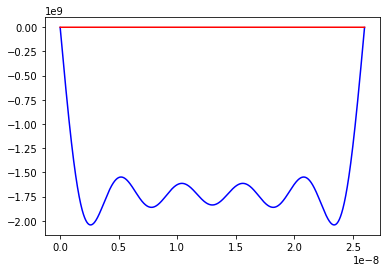

0.2245441309768765


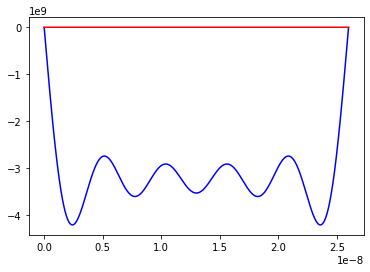

0.11627119144194845


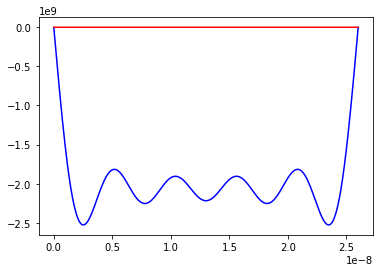

0.20809935043798297


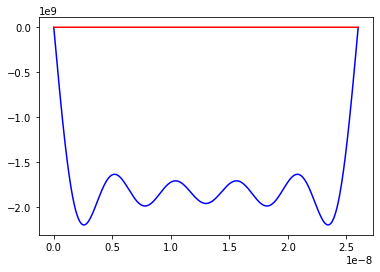

0.22536953861080986


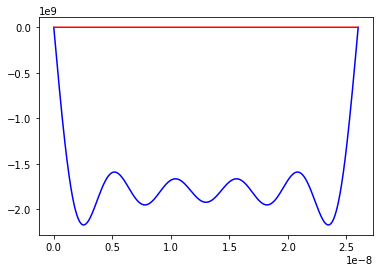

0.22537061305982325


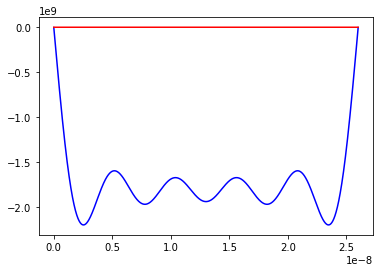

0.22543022732851767


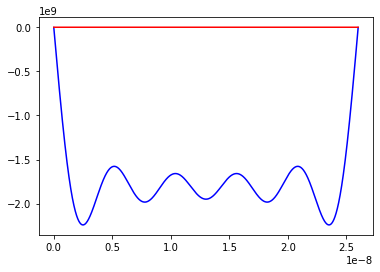

0.22547966359756605


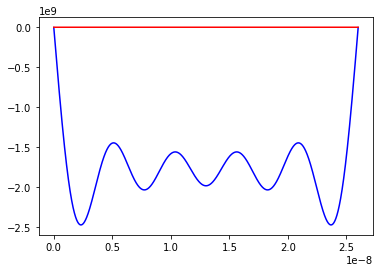

0.2256471690700244


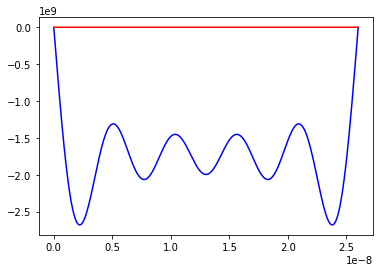

0.2258925693638797


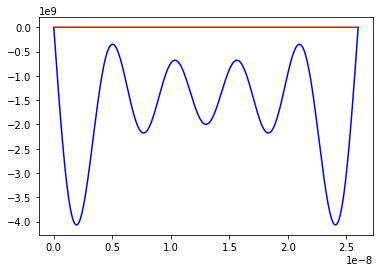

0.2152087193922636


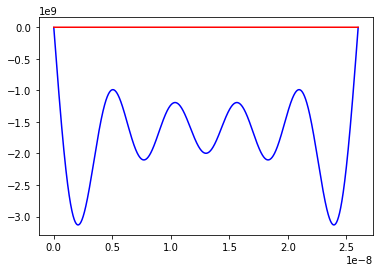

0.2262793286934152


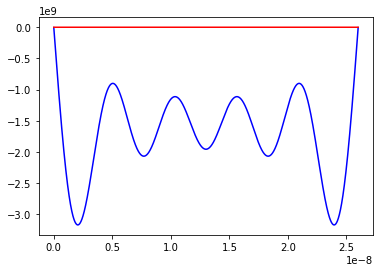

0.22754513255431916


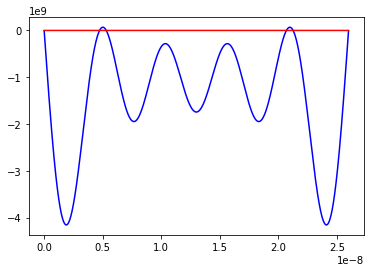

0.2273654025542286


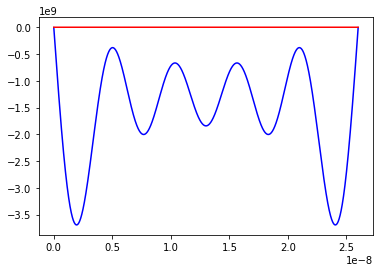

0.22968271008497848


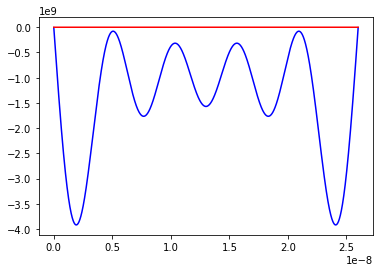

0.23288118711194566


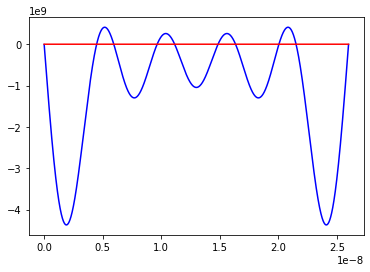

0.23546771198181085


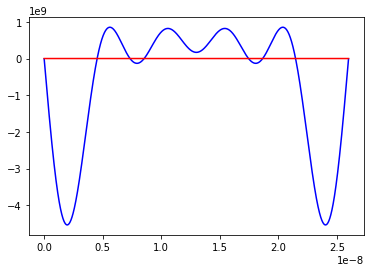

0.23834012001803204


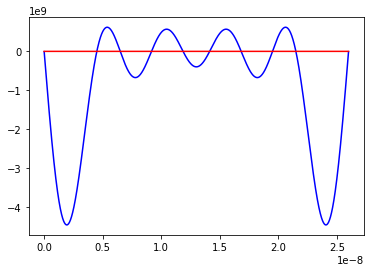

0.23933228078240448


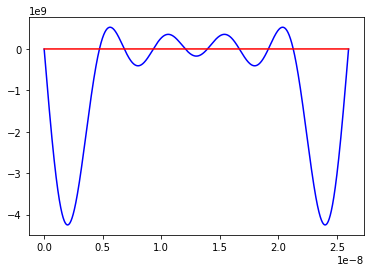

0.24060821585384304


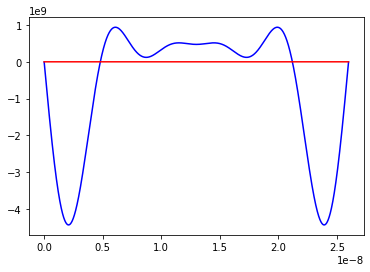

0.24060286205599324


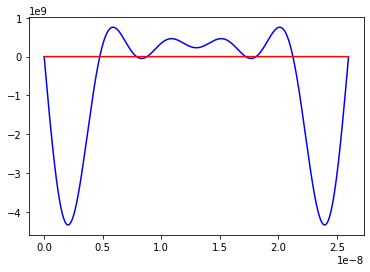

0.24195878839152118


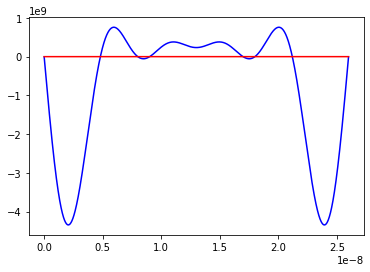

0.24231856144903163


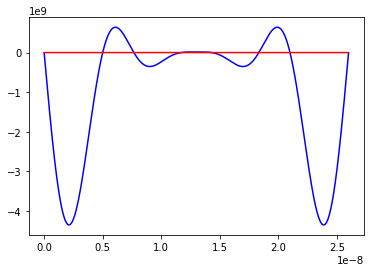

0.24283401490314038


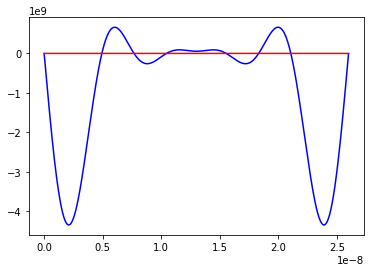

0.24291193514662332


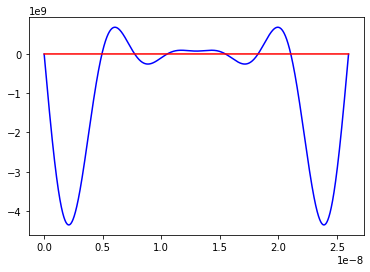

0.24292452573565979


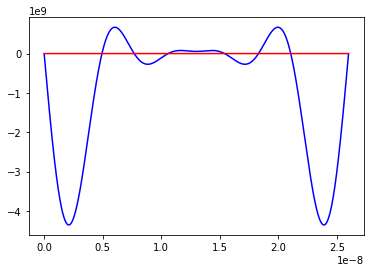

0.2429263536999279


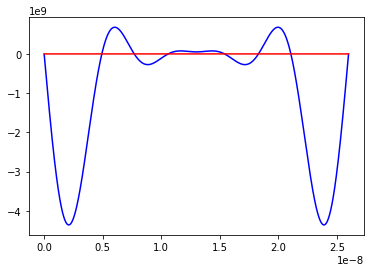

0.24292706516782112


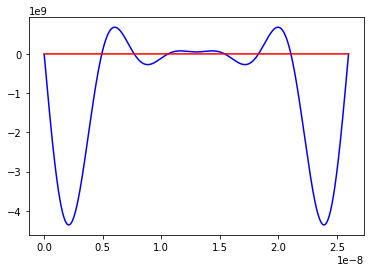

0.24292711622870414


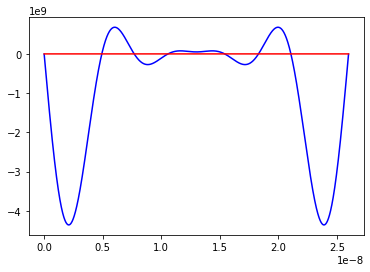

0.24292711995150956


In [26]:
with tf.device('/CPU:0'):
    opt.optimize_controls(
        sim=sim,
        opt_map=opt_map,
        opt='lbfgs',
        opt_name='openloop',
        fid_func=CZ_phase
    )

In [27]:
gates.get_parameters(opt_map)

(array([[0.20556309, 0.55445601, 0.73235651, 0.66682499, 0.26044416],
        [0.        , 0.        , 0.        , 0.        , 0.        ]]),
 array([[0., 2., 0., 2., 0., 2., 0., 2., 0., 2.],
        [0., 2., 0., 2., 0., 2., 0., 2., 0., 2.]]))

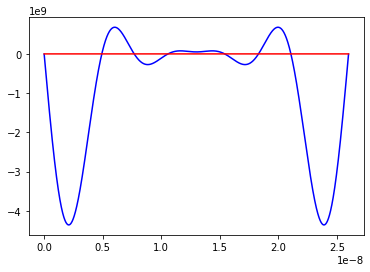

In [28]:
#Check unitary
params, _ = gates.get_parameters(opt_map)
U_dict = sim.get_gates(params, opt_map)
U = U_dict['CZ']
# U = U_dict['Y90p_Q1']

In [29]:
tf.math.angle(tf.linalg.diag_part(U))

<tf.Tensor: id=12881325, shape=(9,), dtype=float64, numpy=
array([ 2.43839053,  2.97521074,  2.36058815,  2.05999572, -2.92319132,
       -2.75520347, -2.38363945, -2.78925586, -1.78522487])>

In [30]:
CZ_phase(U_dict)

0.24292711995149857


<tf.Tensor: id=12881357, shape=(1,), dtype=float64, numpy=array([0.72264292])>

# Plotting

You can run the code below in a different kernel to get a live plot. Or look a the log e.g.

$ less /tmp/c3logs/recent/openloop.log
(press F to get a continuous feed)

ValueError: x and y must have same first dimension, but have shapes (22,) and (44, 5)

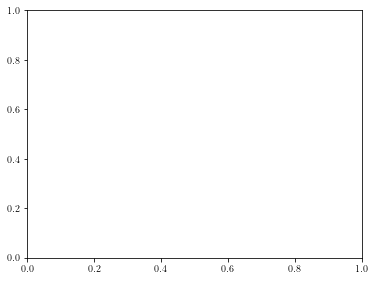

In [31]:
from c3po.display import plot_OC_logs
plot_OC_logs("/tmp/c3logs/recent/openloop.log")